In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import dask
dask.config.set(scheduler='threads')

In [4]:
# Remote Zarr Data Linking (CHIRPS Complete)
store_url = "https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/chirps_feedstock/chirps-global-daily.zarr"
# Load Zarr Data
ds = xr.open_dataset(store_url, engine="zarr", consolidated=True)

# Automatically determine latitude order and crop Ghana region (4°N-11°N, -3°-2°E)
lat_min, lat_max = 4, 11
if ds.latitude[0] < ds.latitude[-1]:
    lat_slice = slice(lat_min, lat_max)
else:
    lat_slice = slice(lat_max, lat_min)

ghana_ds = ds.sel(
    latitude=lat_slice,
    longitude=slice(-3, 2),
    time=slice("2000-01-01", "2020-12-31")
)

# Save as NetCDF file
ghana_ds.to_netcdf("/home/jovyan/Project_Ghana/ghana_chirps_2000_2020.nc")

ds = xr.open_dataset("/home/jovyan/Project_Ghana/ghana_chirps_2000_2020.nc")
precip = ds['precip']

print(precip)

precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6])).compute()

print(precip.shape) 

<xarray.DataArray 'precip' (time: 7671, latitude: 140, longitude: 100)> Size: 430MB
[107394000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 560B 4.025 4.075 4.125 ... 10.87 10.92 10.97
  * longitude  (longitude) float32 400B -2.975 -2.925 -2.875 ... 1.925 1.975
  * time       (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
Attributes:
    geostatial_lat_max:  50.0
    geostatial_lat_min:  -50.0
    geostatial_lon_max:  180.0
    geostatial_lon_min:  -180.0
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    standard_name:       convective precipitation rate
    time_step:           day
    units:               mm/day
(2562, 140, 100)


In [2]:
# Figure 1 #

In [57]:
years = np.arange(2000, 2021)

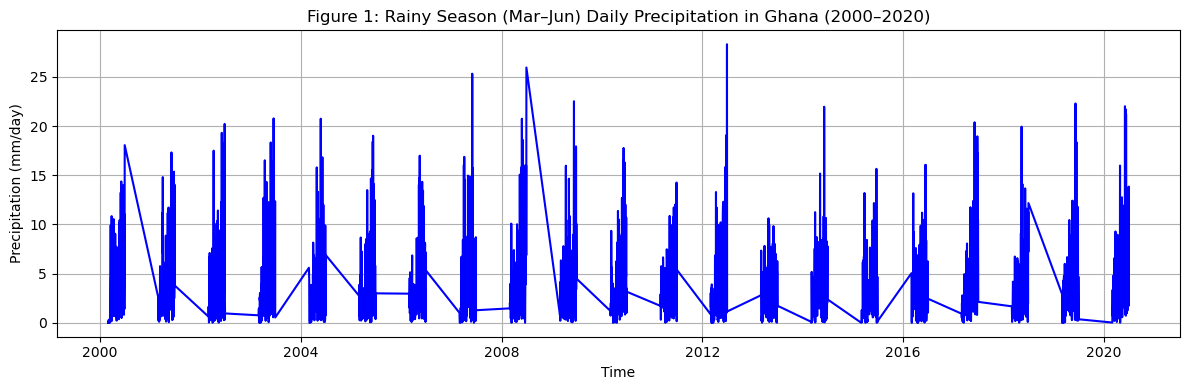

In [75]:
rainy_season = precip.where(precip['time'].dt.month.isin([3, 4, 5, 6]), drop=True)
precip['time'] = pd.to_datetime(precip['time'].values)

monthly_series = rainy_season.mean(dim=['latitude', 'longitude'])

plt.figure(figsize=(12, 4))
monthly_series.plot(color='blue')
plt.title("Figure 1: Rainy Season (Mar–Jun) Daily Precipitation in Ghana (2000–2020)")
plt.xlabel("Time")
plt.ylabel("Precipitation (mm/day)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
print(rainy_season['time'])

<xarray.DataArray 'time' (time: 2562)> Size: 20kB
array(['2000-03-01T00:00:00.000000000', '2000-03-02T00:00:00.000000000',
       '2000-03-03T00:00:00.000000000', ..., '2020-06-28T00:00:00.000000000',
       '2020-06-29T00:00:00.000000000', '2020-06-30T00:00:00.000000000'],
      shape=(2562,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 20kB 2000-03-01 2000-03-02 ... 2020-06-30
Attributes:
    axis:           T
    standard_name:  time


In [69]:
print(rainy_season['time'].values[:10])

['2000-03-01T00:00:00.000000000' '2000-03-02T00:00:00.000000000'
 '2000-03-03T00:00:00.000000000' '2000-03-04T00:00:00.000000000'
 '2000-03-05T00:00:00.000000000' '2000-03-06T00:00:00.000000000'
 '2000-03-07T00:00:00.000000000' '2000-03-08T00:00:00.000000000'
 '2000-03-09T00:00:00.000000000' '2000-03-10T00:00:00.000000000']


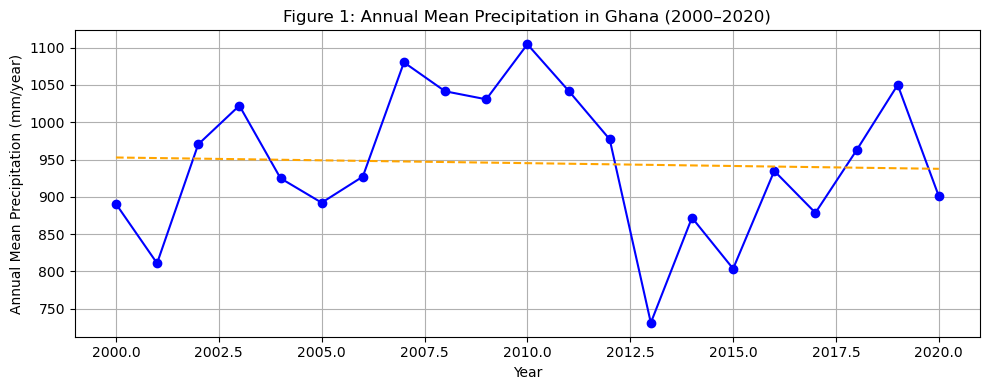

In [66]:
annual_precip = precip.groupby('time.year').sum(dim='time')

annual_mean_precip = annual_precip.mean(dim=['latitude', 'longitude'])

years = annual_mean_precip.year.values
values = annual_mean_precip.values

slope, intercept = np.polyfit(years, values, 1)
trend = slope * years + intercept

plt.figure(figsize=(10, 4))
plt.plot(years, values, marker='o', linestyle='-', color='blue')
plt.plot(years, trend, linestyle='--', color='orange', label=f'Trend (slope = {slope:.2f} mm/year)')
plt.title("Figure 1: Annual Mean Precipitation in Ghana (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Annual Mean Precipitation (mm/year)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Figure 2 #

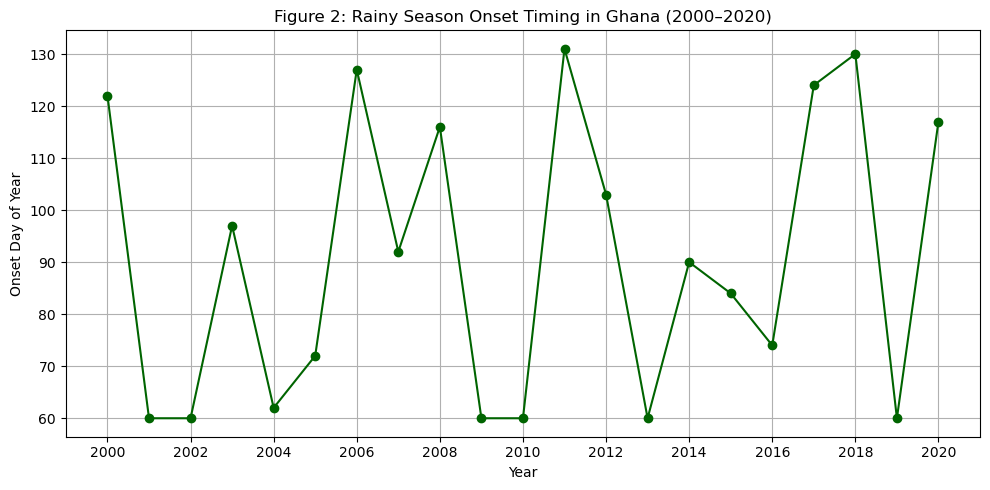

In [42]:
precip = ds['precip']

rainy_season = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

rolling = rainy_season.rolling(time=5).mean()

threshold = 5
onset_days = []

for year in years:
    season = rolling.sel(time=str(year))
    mean_over_space = season.mean(dim=['latitude', 'longitude'])
    
    condition = mean_over_space > threshold
    if condition.any():
        onset_day = condition.argmax(dim='time')
        onset_date = mean_over_space.time[onset_day]
        onset_days.append(onset_date.dt.dayofyear.values)
    else:
        onset_days.append(np.nan)

# Plot Onset Timing
plt.figure(figsize=(10, 5))
plt.plot(years, onset_days, marker='o', linestyle='-', color='darkgreen')
plt.title("Figure 2: Rainy Season Onset Timing in Ghana (2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("Onset Day of Year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
import pandas as pd

In [48]:
for y, d in zip(years, onset_days):
    print(f"{y}: Day {d} ≈ {pd.to_datetime(f'{y}-01-01') + pd.to_timedelta(int(d), unit='D')}")

2000: Day 122 ≈ 2000-05-02 00:00:00
2001: Day 60 ≈ 2001-03-02 00:00:00
2002: Day 60 ≈ 2002-03-02 00:00:00
2003: Day 97 ≈ 2003-04-08 00:00:00
2004: Day 62 ≈ 2004-03-03 00:00:00
2005: Day 72 ≈ 2005-03-14 00:00:00
2006: Day 127 ≈ 2006-05-08 00:00:00
2007: Day 92 ≈ 2007-04-03 00:00:00
2008: Day 116 ≈ 2008-04-26 00:00:00
2009: Day 60 ≈ 2009-03-02 00:00:00
2010: Day 60 ≈ 2010-03-02 00:00:00
2011: Day 131 ≈ 2011-05-12 00:00:00
2012: Day 103 ≈ 2012-04-13 00:00:00
2013: Day 60 ≈ 2013-03-02 00:00:00
2014: Day 90 ≈ 2014-04-01 00:00:00
2015: Day 84 ≈ 2015-03-26 00:00:00
2016: Day 74 ≈ 2016-03-15 00:00:00
2017: Day 124 ≈ 2017-05-05 00:00:00
2018: Day 130 ≈ 2018-05-11 00:00:00
2019: Day 60 ≈ 2019-03-02 00:00:00
2020: Day 117 ≈ 2020-04-27 00:00:00


In [ ]:
# Figure 3 #

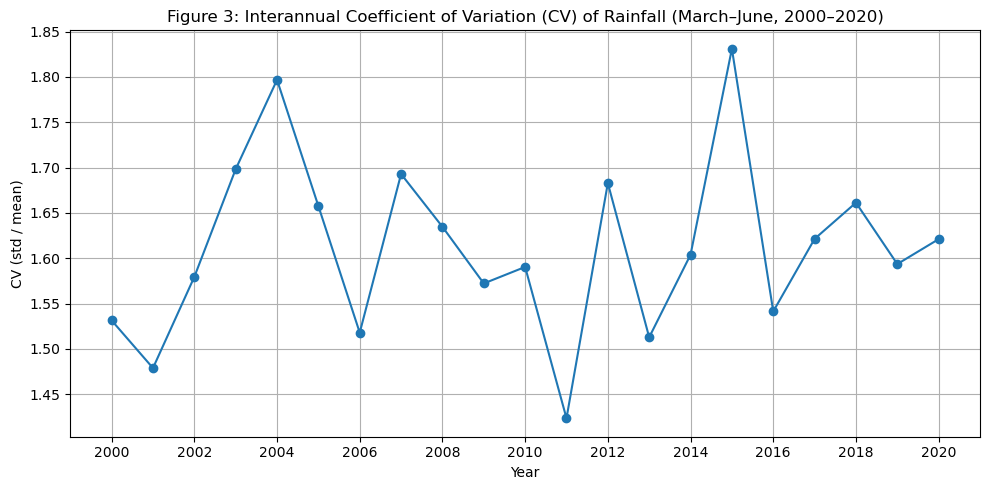

In [36]:
precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

# Group by year and compute mean and std over time and space
season_mean = precip.groupby('time.year').mean(dim=['time', 'latitude', 'longitude'])
season_std = precip.groupby('time.year').std(dim=['time', 'latitude', 'longitude'])

# Calculate Coefficient of Variation (CV)
cv = season_std / season_mean

# Plot CV time series
plt.figure(figsize=(10, 5))
cv.plot(marker='o')
plt.title("Figure 3: Interannual Coefficient of Variation (CV) of Rainfall (March–June, 2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("CV (std / mean)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
import geopandas as gpd
import rioxarray

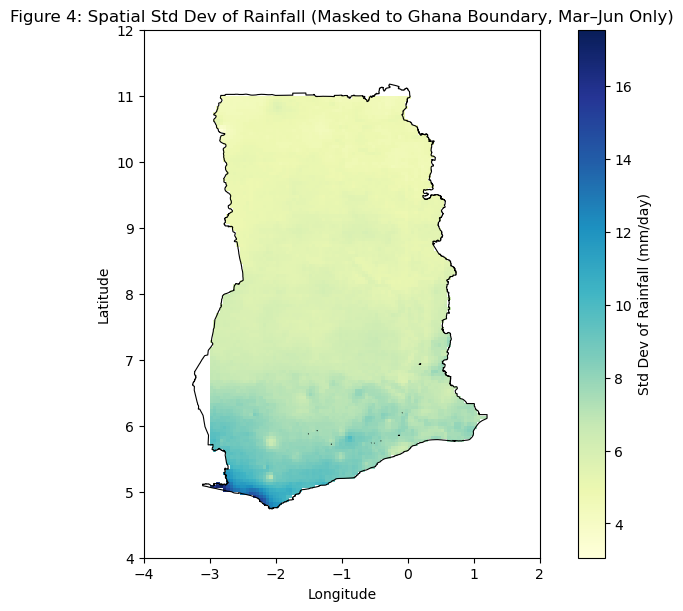

In [52]:
ghana_shape = gpd.read_file("gadm41_GHA_shp/gadm41_GHA_0.shp")  # Level 0

rainy_season = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

spatial_std = rainy_season.std(dim='time')

spatial_std.rio.write_crs("EPSG:4326", inplace=True)

masked_std = spatial_std.rio.clip(ghana_shape.geometry, ghana_shape.crs, drop=True)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True) 
masked_std.plot(
    ax=ax,
    cmap="YlGnBu",
    cbar_kwargs={'label': 'Std Dev of Rainfall (mm/day)'}
)
ghana_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

ax.set_title("Figure 4: Spatial Std Dev of Rainfall (Masked to Ghana Boundary, Mar–Jun Only)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-4, 2)
ax.set_ylim(4, 12)
ax.set_aspect('equal')
plt.show()

In [50]:
print(ds.latitude.max().values)

10.974998


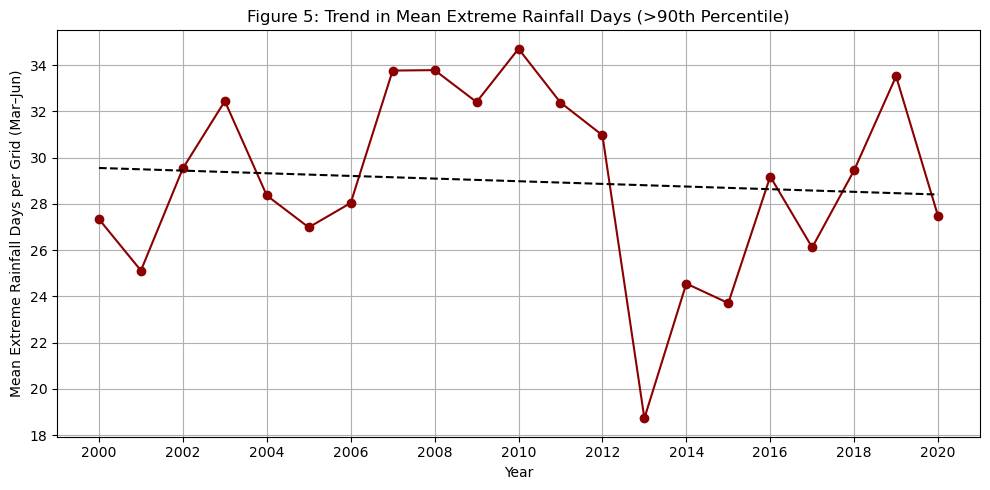

In [56]:
rainy_season = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

# Calculation of 90th percentile threshold (across time)
q90 = precip.quantile(0.9, dim='time')

# Create Boolean masks for extreme precipitation
threshold_mask = precip > q90

# How many extreme days per grid per year (summed across time)
extreme_days_per_year = threshold_mask.groupby('time.year').sum(dim='time')

# Average extreme days per grid (averaged across space)
mean_extreme_days = extreme_days_per_year.mean(dim=['latitude', 'longitude'])

years = mean_extreme_days.year.values
counts = mean_extreme_days.values

slope, intercept = np.polyfit(years, counts, 1)
trendline = slope * years + intercept

plt.figure(figsize=(10, 5))
plt.plot(years, counts, marker='o', linestyle='-', color='darkred')
plt.plot(years, trendline, linestyle='--', color='black', label=f'Trend Line (slope={slope:.2f})')
plt.title("Figure 5: Trend in Mean Extreme Rainfall Days (>90th Percentile)")

plt.xlabel("Year")
plt.ylabel("Mean Extreme Rainfall Days per Grid (Mar–Jun)")
plt.xticks(np.arange(2000, 2021, 2))
plt.grid(True)
plt.tight_layout()
plt.show()